In [2]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import pytz

In [3]:
def add_lt(df,tz):
    df["lt"] = df.index.tz_localize(pytz.utc).tz_convert(pytz.timezone(tz))
    return df

def load_scws(rid,tz):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({0:2,1:0,2:1})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1 = add_lt(df1,tz)    
    df1["month"] = df1.index.month
    df1["hour"] = df1["lt"].dt.hour
    df1["year"] = df1.index.year
    df1["aspect_ratio"] = df1.major_axis_length / df1.minor_axis_length    
    
    df2["cluster_new"] = df2.cluster.map({0:2,1:0,2:1})
    df2 = df2.set_index(pd.DatetimeIndex(df2.dt_utc))
    df2 = add_lt(df2,tz)            
    df2["month"] = df2.index.month
    df2["hour"] = df2["lt"].dt.hour
    df2["year"] = df2.index.year    
    df2["aspect_ratio"] = df2.major_axis_length / df2.minor_axis_length     
    
    df1["rid"] = rid
    df2["rid"] = rid

    
    return df1, df2

In [4]:
melb_scw, melb_null = load_scws("2",'Australia/Melbourne')
bris_scw, bris_null = load_scws("66",'Australia/Brisbane')
namoi_scw, namoi_null = load_scws("69",'Australia/Sydney')
perth_scw, perth_null = load_scws("70",'Australia/Perth')
syd_scw, syd_null = load_scws("71",'Australia/Sydney')

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


In [5]:
data=pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw,
               ], axis=0).dropna(subset=["azi_shear"])
data["scw"]=1
data_null=pd.concat([melb_null.query("in10km==1"), 
                     syd_null.query("in10km==1"), 
                     bris_null.query("in10km==1"),
                     perth_null.query("in10km==1"), 
                     namoi_null.query("in10km==1")], axis=0).dropna(subset=["azi_shear60"])
data_null=data_null.drop_duplicates(["year","month","rid","uid10"])
#data_null["cluster_new"] = -1
data = pd.concat([data,data_null],axis=0).set_index("stn_id",append=True)

#Linear
data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Cluster of cells
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Linear hybrid
data.loc[(data.max_alt>=7) & (data.azi_shear60>4) & ((data.major_axis_length>=100)),"class2"] = "Embedded supercell"
#Shallow
#data.loc[(data.max_alt<7.0),"class2"] = "Shallow"

<AxesSubplot:>

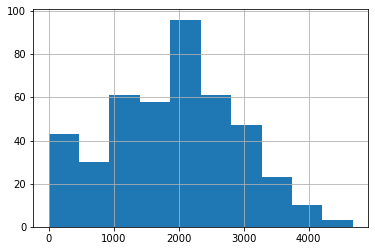

In [6]:
data[(data.class2=="Supercellular") | (data.class2=="Embedded supercell")].mu_cape.hist()

In [7]:
data[data.max_alt>=7].mu_cape.median()

1381.25

## Probability of storm classes for each environmental cluster

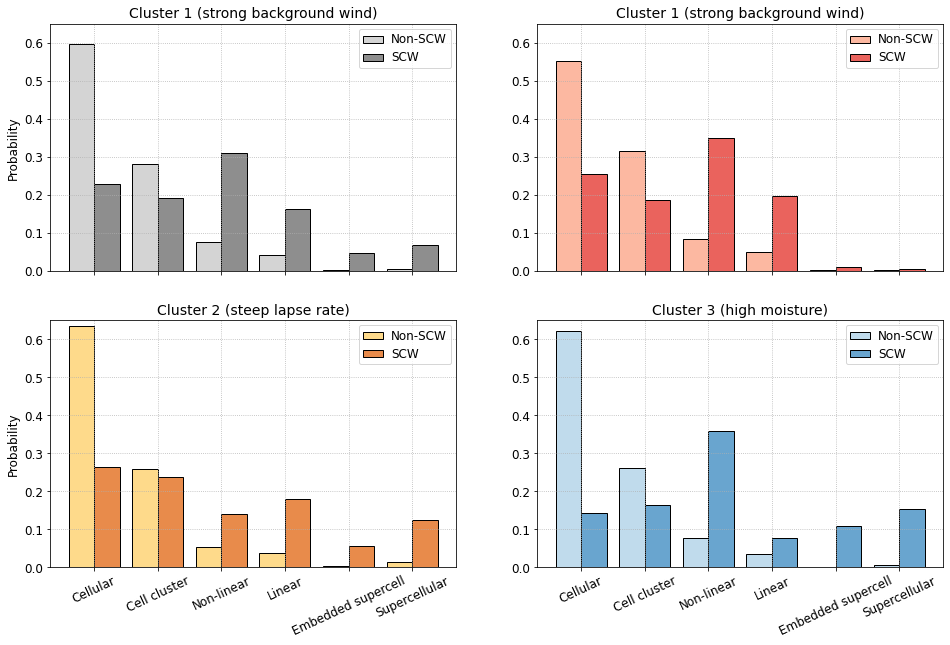

In [8]:
#sns.catplot(data=data[data.cluster==1],x="class2",kind="count")
#data.class2.map({"Cellular":0,"Cell cluster":1,"
order = ["Cellular","Cell cluster","Non-linear","Linear","Embedded supercell","Supercellular"]
data["class3"] = data.class2.map(dict(zip(order, np.arange(len(order)))))

plt.figure(figsize=[16,10])

ax=plt.subplot(2,2,1)
h=sns.histplot(data,x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Greys")
ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0,0.65]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 1 (strong background wind)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("Probability",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Non-SCW", "SCW")):
    t.set_text(l)

ax=plt.subplot(2,2,2)
h=sns.histplot(data[data.cluster==1],x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Reds")
ax.set_xticks(np.arange(len(order)),labels=""); ax.set_ylim([0,0.65]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 1 (strong background wind)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Non-SCW", "SCW")):
    t.set_text(l)

ax=plt.subplot(2,2,3)
h=sns.histplot(data[data.cluster==2],x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="YlOrBr")
ax.set_xticks(np.arange(len(order)),labels=order); ax.set_ylim([0,0.65]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 2 (steep lapse rate)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("Probability",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Non-SCW", "SCW")):
    t.set_text(l)

ax=plt.subplot(2,2,4)
h=sns.histplot(data[data.cluster==0],x="class3",stat="probability",hue="scw",common_norm=False,multiple="dodge",shrink=0.8,discrete=True,palette="Blues")
ax.set_xticks(np.arange(len(order)),labels=order); ax.set_ylim([0,0.65]); ax.tick_params(axis="x",rotation=25); ax.grid(ls=":")
ax.set_title("Cluster 3 (high moisture)",size=14); ax.set_xlabel(""); ax.tick_params(axis="both",labelsize=12); ax.set_ylabel("",size=12)
h.legend_.set_title(""); plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text
for t, l in zip(h.legend_.texts,("Non-SCW", "SCW")):
    t.set_text(l)

## Seasonal cycle of storm classes (non SCWs and SCWs)

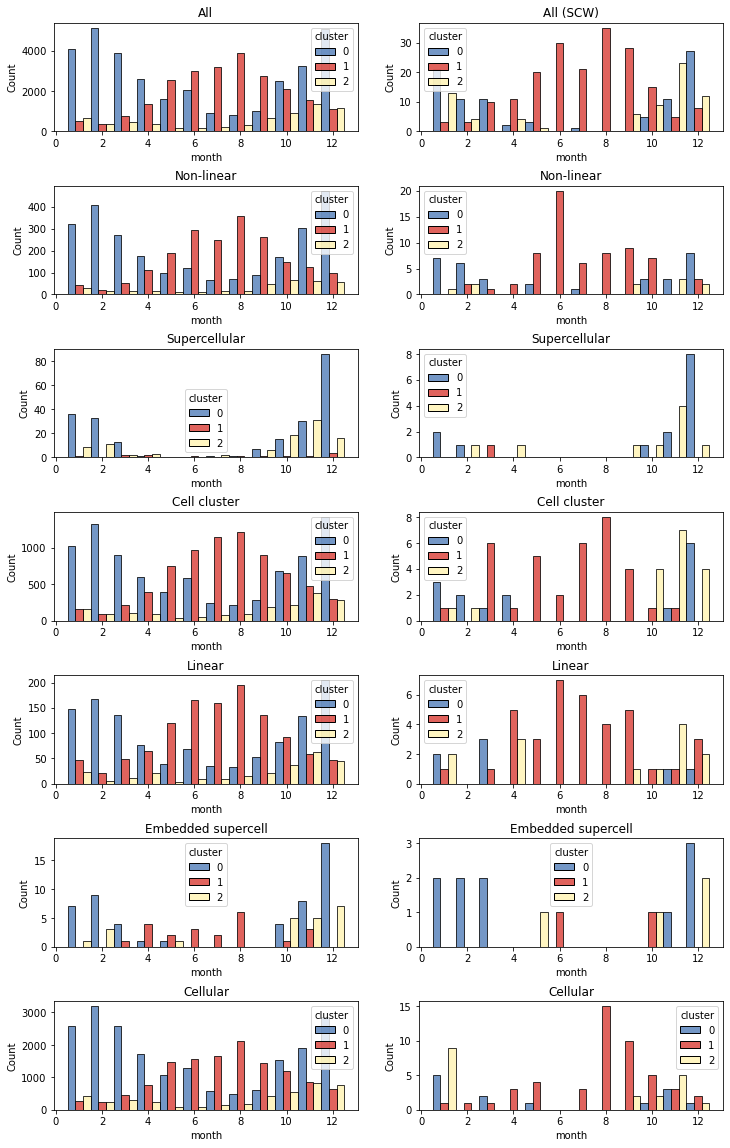

In [9]:
def plot_annual_hist(data,ax,class2=""):
    if class2=="":
        sns.histplot(\
                     data=data,
                     x="month",
                     hue="cluster",
                     multiple="dodge",
                     stat="count",
                     common_norm=False,
                     common_bins=False,
                    discrete=True,kde=False,
                    palette=[plt.get_cmap("RdYlBu")(i) for i in [0.9,0.1,0.46]])
    else:
        sns.histplot(\
                     data=data[data.class2==class2],
                     x="month",
                     hue="cluster",
                     multiple="dodge",
                     stat="count",
                     common_norm=False,
                     common_bins=False,
                    discrete=True,kde=False,
                    palette=[plt.get_cmap("RdYlBu")(i) for i in [0.9,0.1,0.46]])
    plt.title(class2)

plt.figure(figsize=[12,20])

plot_annual_hist(data,plt.subplot(7,2,1)); plt.title("All")
plot_annual_hist(data,plt.subplot(7,2,3),"Non-linear")
plot_annual_hist(data,plt.subplot(7,2,5),"Supercellular")
plot_annual_hist(data,plt.subplot(7,2,7),"Cell cluster")
plot_annual_hist(data,plt.subplot(7,2,9),"Linear")
plot_annual_hist(data,plt.subplot(7,2,11),"Embedded supercell")
plot_annual_hist(data,plt.subplot(7,2,13),"Cellular")

plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,2)); plt.title("All (SCW)")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,4),"Non-linear")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,6),"Supercellular")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,8),"Cell cluster")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,10),"Linear")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,12),"Embedded supercell")
plot_annual_hist(data.query("scw==1"),plt.subplot(7,2,14),"Cellular")

plt.subplots_adjust(hspace=0.5)

## Environmental conditions for each storm class

In [10]:
def plot_violin(data, v, cluster, order, ax, title=False, label=False):

    ys = {"s06":"linear","qmean01":"linear","Umean06":"linear","lr13":"linear","s01":"linear","ebwd":"linear","s03":"linear",
         "mu_cape":"linear","dcape":"linear","mu_lcl":"linear","ml_lcl":"linear"}
    vmin = {"s06":0,"qmean01":2.5,"lr13":1,"Umean06":0,"s01":0,"ebwd":0,"s03":0,"mu_cape":0,"dcape":0,"mu_lcl":0,"ml_lcl":0}
    vmax = {"s06":None,"qmean01":20,"lr13":10.5,"Umean06":40,"s01":40,"ebwd":60,"s03":60,"mu_cape":4000,"dcape":2000,"mu_lcl":5000,"ml_lcl":5000}
    cols = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    titles = {0:"Cluster 1 (strong background winds)",1:"Cluster 2 (steep lapse rates)",2:"Cluster 3 (high moisture)"}
    labels = {"qmean01":"Qmean01 (g/kg)","lr13":"LR13 (K/km)","Umean06":"Umean06 (m/s)","s06":"S06 (m/s)","ebwd":"EBWD","s01":"S01","s03":"S03",
             "mu_cape":"MUCAPE","dcape":"DCAPE","mu_lcl":"MULCL","ml_lcl":"MLLCL"}
    
    sns.violinplot(data=data[data.cluster_new==cluster],x="class2",y=v,scale="width",
               order=order,cut=0,inner="quartile",ax=ax,color=cols[cluster])
    plt.yscale(ys[v])
    plt.ylim([vmin[v],vmax[v]])
    plt.gca().tick_params("x",rotation=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel("")
    ax.grid(axis="y",ls=":")
    if title:
        plt.title(titles[cluster],size=14)
    if label:
        ax.set_ylabel(labels[v],size=12)
    else:
        ax.set_ylabel("")
        
        
def plot_violin_split(data, v, cluster, order, ax, title=False, label=False, sample_size="top",legend=False):

    ys = {"s06":"linear","qmean01":"linear","Umean06":"linear","lr13":"linear","s01":"linear","ebwd":"linear","s03":"linear",
         "mu_cape":"linear","dcape":"linear","mu_lcl":"linear","ml_lcl":"linear"}
    vmin = {"s06":0,"qmean01":2.5,"lr13":1,"Umean06":0,"s01":0,"ebwd":0,"s03":0,"mu_cape":0,"dcape":0,"mu_lcl":0,"ml_lcl":0}
    vmax = {"s06":None,"qmean01":22,"lr13":12,"Umean06":45,"s01":40,"ebwd":60,"s03":60,"mu_cape":5000,"dcape":2500,"mu_lcl":5000,"ml_lcl":6000}
    cols = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    titles = {0:"Cluster 1 (strong background winds)",1:"Cluster 2 (steep lapse rates)",2:"Cluster 3 (high moisture)"}
    labels = {"qmean01":"Qmean01 (g/kg)","lr13":"LR13 (K/km)","Umean06":"Umean06 (m/s)","s06":"S06 (m/s)","ebwd":"EBWD","s01":"S01","s03":"S03",
             "mu_cape":"MUCAPE","dcape":"DCAPE","mu_lcl":"MULCL","ml_lcl":"MLLCL"}
    
    sns.violinplot(data=data[data.cluster_new==cluster],x="class2",y=v,scale="width",
               order=order,cut=0,inner="quartile",ax=ax,color=cols[cluster],hue="scw",split=True)
    plt.yscale(ys[v])
    plt.ylim([vmin[v],vmax[v]])
    plt.gca().tick_params("x",rotation=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel("")
    ax.grid(axis="y",ls=":")
    ax.legend_.remove()
    
    cnt=0 
    for c in order:
        sample_text = str([data[(data.class2==c) & (data.cluster_new==cluster) & (data.scw==0)].shape[0]][0]) + \
                "/"+str([data[(data.class2==c) & (data.cluster_new==cluster)].scw.sum()][0])
        if sample_size=="top":
            ax.text(cnt,(ax.get_ylim()[1])*0.9,sample_text,ha="center",bbox={"facecolor":"white"}) 
        elif sample_size=="bottom":
            ax.text(cnt,(ax.get_ylim()[1]-ax.get_ylim()[0])*0.2,sample_text,ha="center",bbox={"facecolor":"white"}) 
        cnt=cnt+1
        #print(sample_text)    
    
    if title:
        plt.title(titles[cluster],size=14)
    if label:
        ax.set_ylabel(labels[v],size=12)
    else:
        ax.set_ylabel("")        
        
    if legend:        
        l = plt.legend(bbox_to_anchor=(0.5,-0.6),loc=8,ncol=2,fontsize=14)
        for t, l in zip(l.texts, ["Non-SCW","SCW"]):
            t.set_text(l)
        


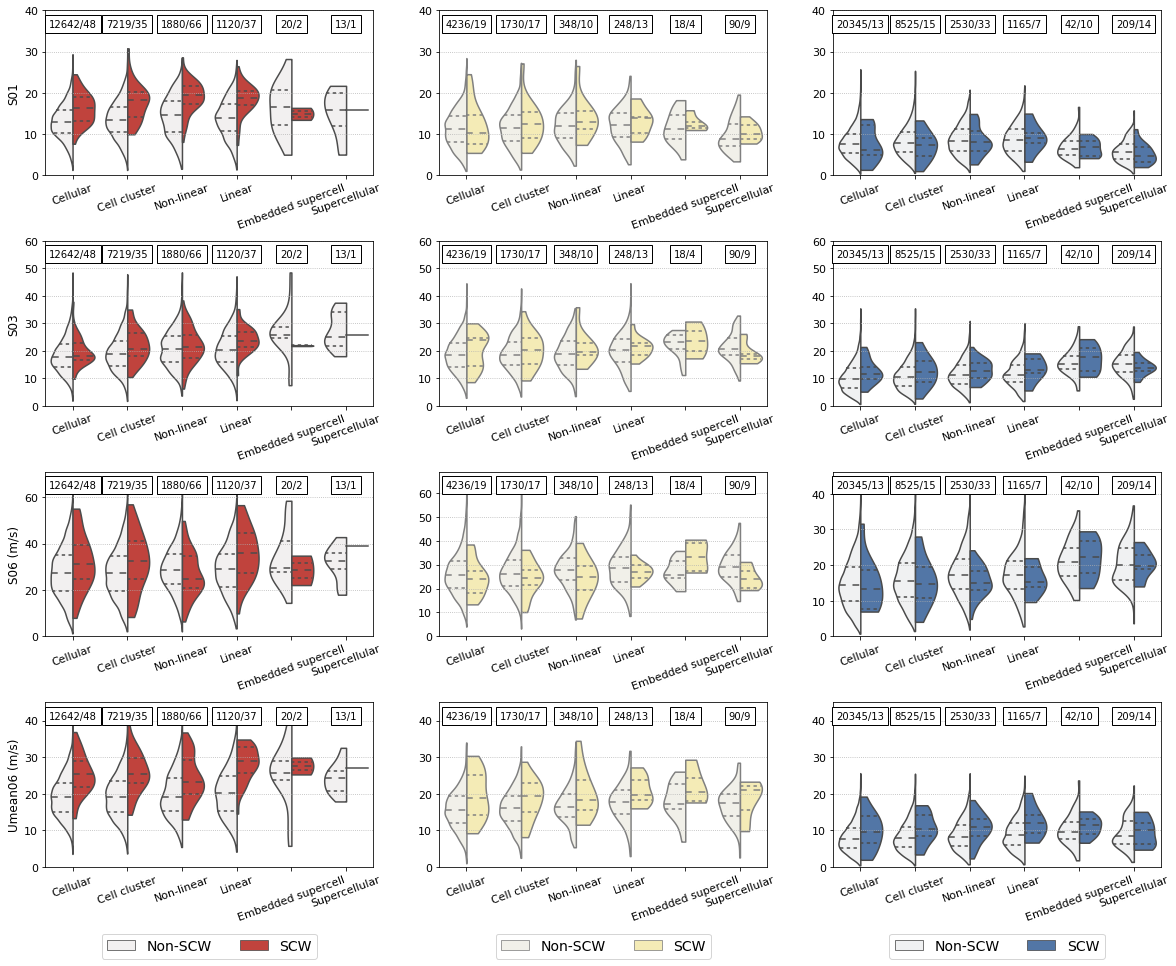

In [11]:
plt.figure(figsize=[20,20])
cnt=1
for v in ["s01","s03","s06","Umean06"]:
    for cluster in [0,1,2]:
        if v=="qmean01":
            title=True
        else:
            title=False
        if cluster==0:
            label=True
        else:
            label=False
        if v=="Umean06":
            legend=True
        else:
            legend=False
            
        plot_violin_split(data, v, cluster, order, plt.subplot(5,3,cnt),title=title,label=label,legend=legend)            
            
        cnt=cnt+1
        
plt.subplots_adjust(hspace=0.4)


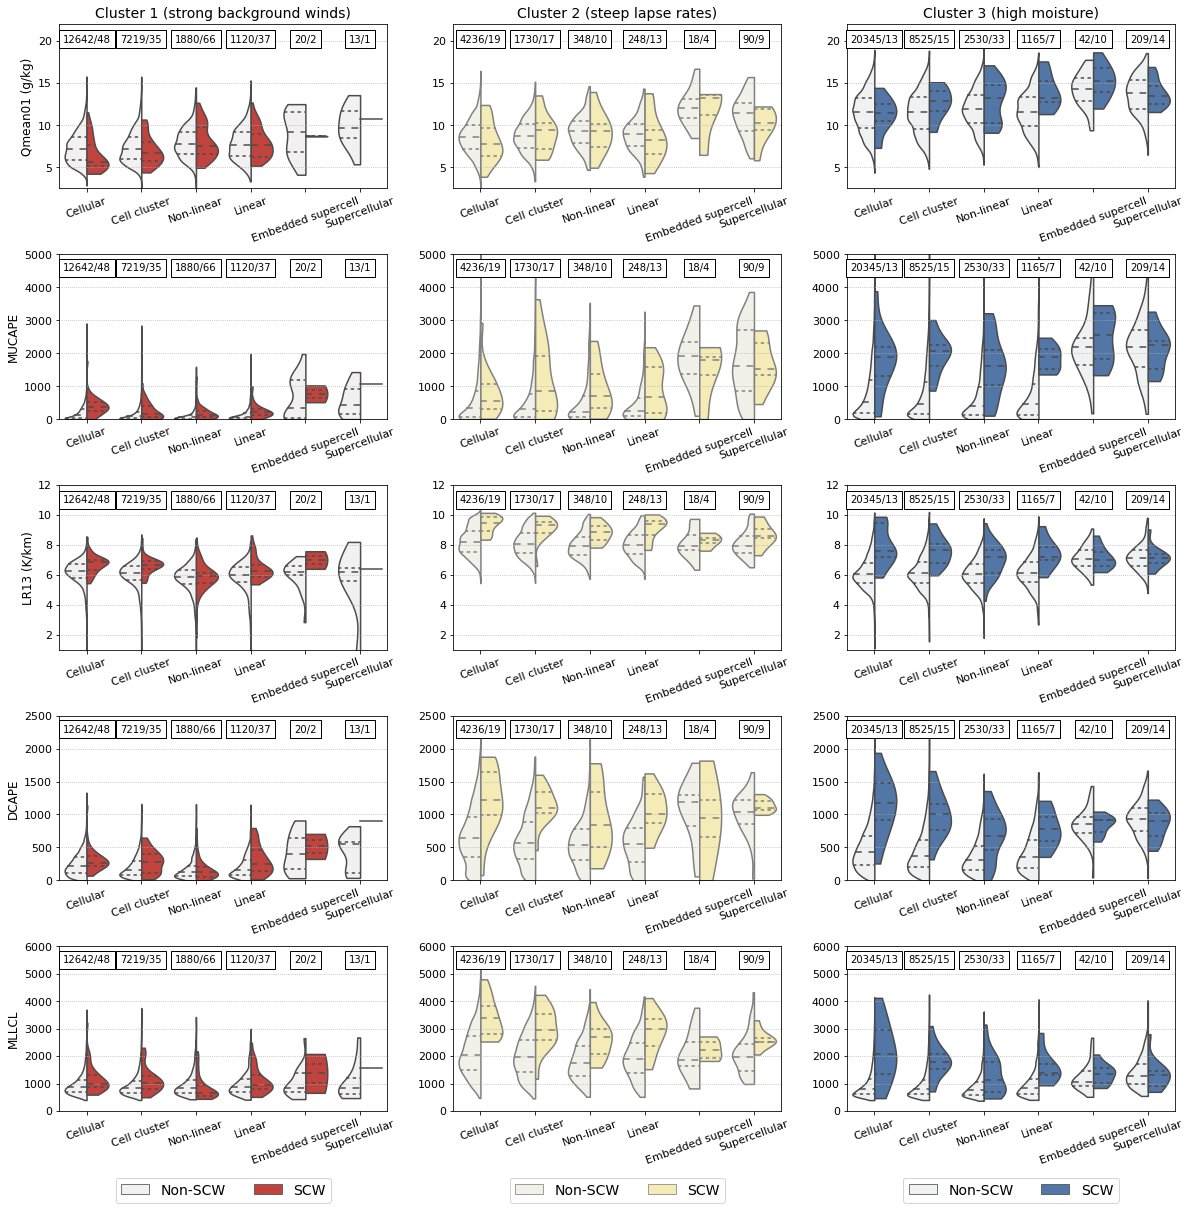

In [12]:
plt.figure(figsize=[20,20])
cnt=1
for v in ["qmean01","mu_cape","lr13","dcape","ml_lcl"]:
    for cluster in [0,1,2]:
        if v=="qmean01":
            title=True
        else:
            title=False
        if cluster==0:
            label=True
        else:
            label=False
        if v=="ml_lcl":
            legend=True
        else:
            legend=False            
            
        plot_violin_split(data, v, cluster, order, plt.subplot(5,3,cnt),title=title,label=label,legend=legend)            
            
        cnt=cnt+1
        
plt.subplots_adjust(hspace=0.4)


## Where it gets interesting: look at discriminating environmental factors (SCW vs. non-SCW) for each environmental cluster/storm class

- DCAPE is important for Cellular, cell cluster, non-linear, and linear events, but only in clusters 2 and 3
- For cluster 1, DCAPE is only maringally different between SCWs and non-SCWs
- For supercells, there is less of a shift for DCAPE between SCWs and non-SCWs for all clusters
- In contrast, Umean06 is shifted to higher values for all clusters/storm classes

## Look at some observed characteristics for the storm classes

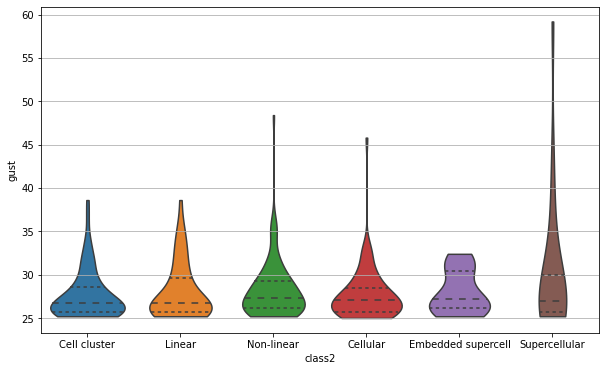

In [43]:
plt.figure(figsize=[10,6])
sns.violinplot(data=data[data.scw==1], x="class2", y="gust",cut=0,inner="quartile")
plt.gca().grid(axis="y")

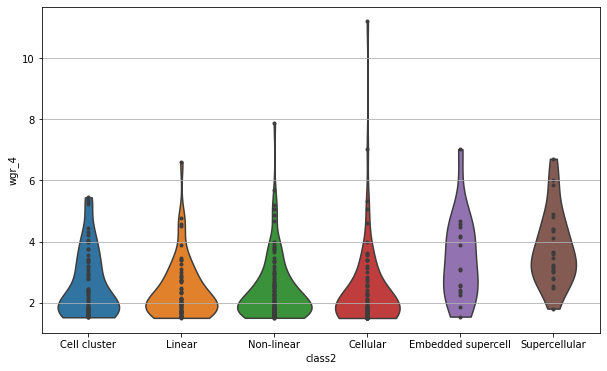

In [14]:
plt.figure(figsize=[10,6])
sns.violinplot(data=data[data.scw==1], x="class2", y="wgr_4",cut=0, inner="points")
plt.gca().grid(axis="y")

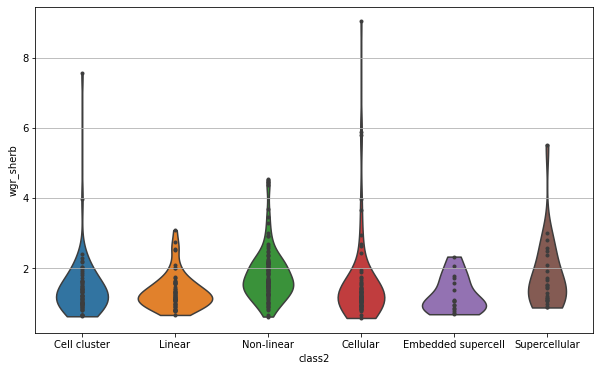

In [15]:
data["wgr_sherb"] = data["gust"] / data["speed"]
plt.figure(figsize=[10,6])
sns.violinplot(data=data[data.scw==1], x="class2", y="wgr_sherb",cut=0, inner="points")
plt.gca().grid(axis="y")

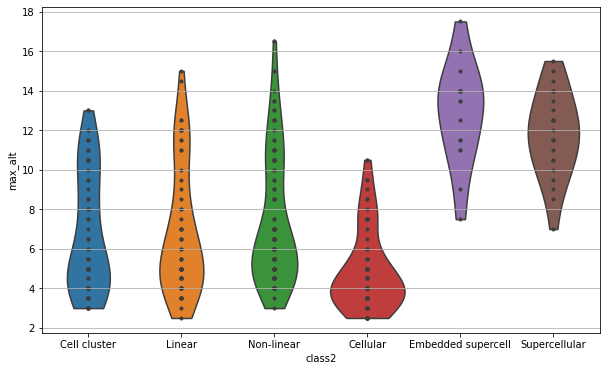

In [16]:
plt.figure(figsize=[10,6])
sns.violinplot(data=data[data.scw==1], x="class2", y="max_alt",cut=0, inner="points")
plt.gca().grid(axis="y")

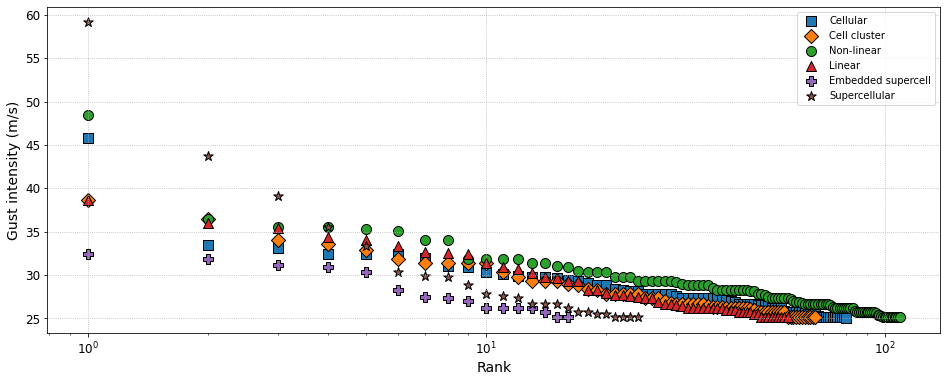

In [42]:
plt.figure(figsize=[16,6])

scatters=[]
markers=["s","D","o","^","P","*"]
cnt=0
for c in order:
    df_sorted = data[(data.class2==c) & (data.scw==1)].sort_values("gust",ascending=False)
    df_sorted["rank"] = np.arange(1,df_sorted.shape[0]+1,1)

    scatters.append(plt.scatter(x=df_sorted["rank"], y=df_sorted["gust"], marker=markers[cnt], edgecolor="k", linewidth=1, s=100, alpha=1))
    cnt=cnt+1
    
plt.legend(order)
    
plt.gca().grid(ls=":")

plt.xscale("log")
plt.yscale("linear")

plt.ylabel("Gust intensity (m/s)",size=14)
plt.xlabel("Rank",size=14)

plt.gca().tick_params(labelsize=12)

